
====== Job Matching System ======



Do you want to display charts in GUI windows? (y/n):  y


Loading job data from: C:\Users\yasse\Downloads\job_title_career_level_governorate_top_skills.csv



Enter the path to your CV file (PDF, DOCX, or TXT):  C:\\Users\\yasse\\Downloads\\Mennatullah-Yasser-Nabile-FlowCV-Resume-20250419.pdf



Processing CV...
CV processed successfully! Found 49 skills.

Your Skills:
analytical, tableau, computer, telecommunication, m, i, com, education, engineering, digital, training, technical, programming, analysis, engineer, learning, industry, science, communication, management, data analyst, of, power, analyst, testing, data analysis, arabic, student, project, github, machine, data visualization, time management, azure, an, data science, research, experience, database, postgresql, a, data, git, microsoft, alexandria, business, machine learning, visual, flask

Finding job recommendations based on your skills...

         TOP JOB MATCHES AND SKILL RECOMMENDATIONS          

1. JOB TITLE: JavaScript Developer
--------------------------------
   MATCH SCORE: 57.7%

   ✅ MATCHED SKILLS:
      analysis | analyst | business
      data | data analysis | data analyst
      research

   ➕ RECOMMENDED SKILLS TO LEARN:
      accounting | computer science | entry level
      finance | information 

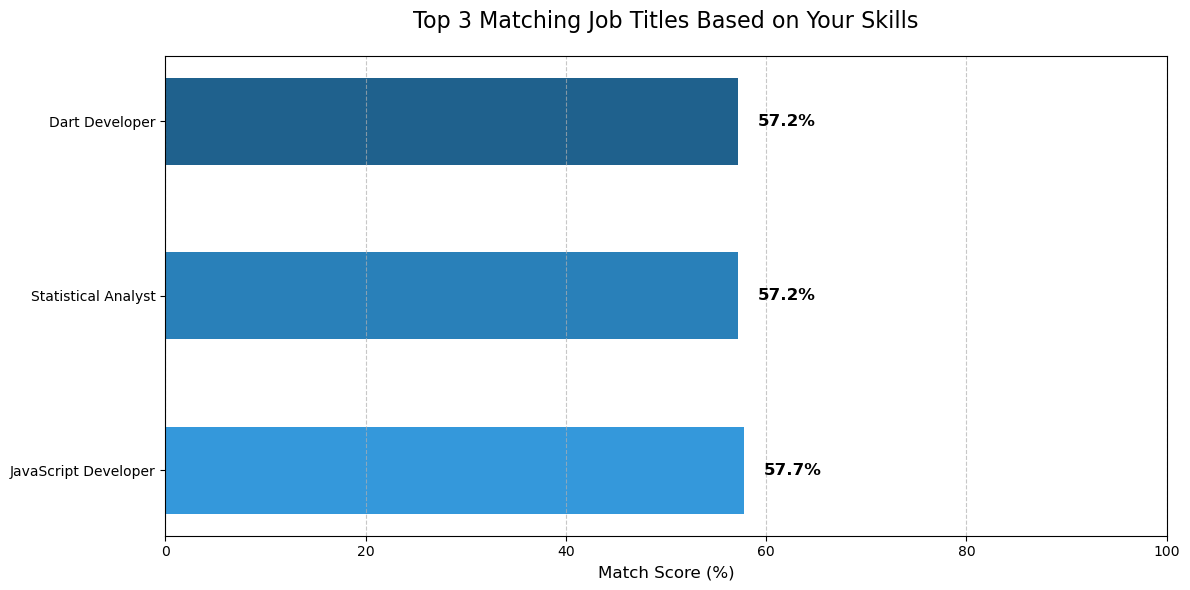

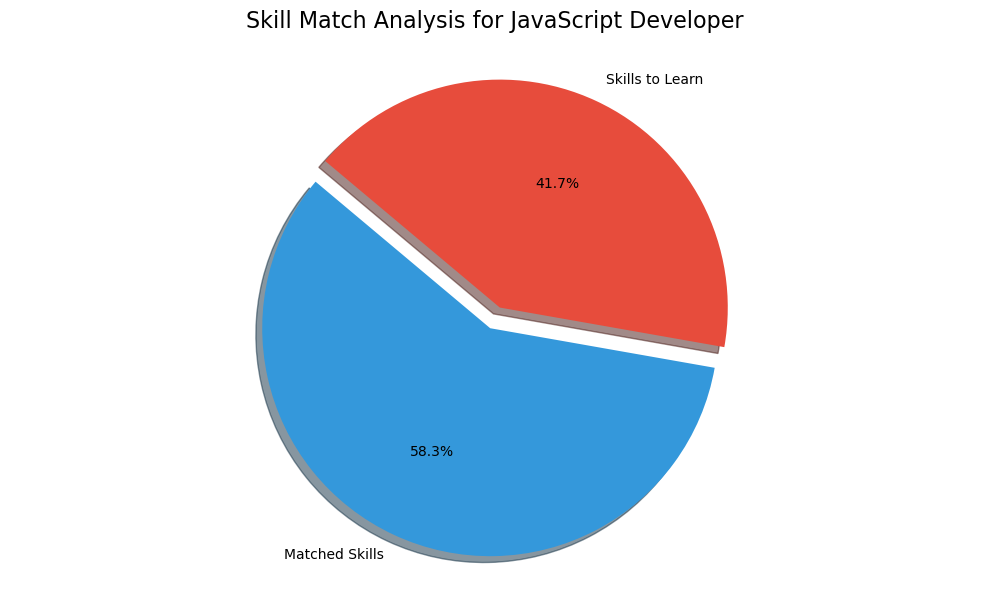

In [2]:
import pandas as pd
import PyPDF2
import docx
import re
import os
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set the path to the job data file directly in the code
# MODIFY THIS PATH to the full path of your CSV/Excel file
JOB_DATA_FILE = "C:/path/to/your/job_title_career_level_governorate_top_skills.csv"

# Function to read Excel/CSV data
def load_data():
    try:
        # Check if file exists
        if not os.path.exists(JOB_DATA_FILE):
            return pd.DataFrame(), f"File not found: {JOB_DATA_FILE}"
            
        # Check file extension
        if JOB_DATA_FILE.endswith('.csv'):
            df = pd.read_csv(JOB_DATA_FILE)
        else:
            df = pd.read_excel(JOB_DATA_FILE)
        
        # Verify that required columns exist
        required_columns = ['Job Title', 'skills', 'Governorate']
        for col in required_columns:
            if col not in df.columns:
                return pd.DataFrame(), f"Missing required column: {col}"
        
        # Check for professional level column (could be either capitalization)
        if 'professional level' not in df.columns and 'professional Level' not in df.columns:
            return pd.DataFrame(), "Missing required column: professional level/Level"
            
        return df, None
    except Exception as e:
        return pd.DataFrame(), f"Error loading data: {e}"

# Function to extract text from CV
def extract_text_from_cv(file_path):
    text = ""
    file_extension = file_path.split('.')[-1].lower()
    
    try:
        if file_extension == 'pdf':
            with open(file_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page in pdf_reader.pages:
                    text += page.extract_text() or ""
                
        elif file_extension == 'docx':
            doc = docx.Document(file_path)
            for para in doc.paragraphs:
                text += para.text + "\n"
                
        elif file_extension == 'txt':
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
        else:
            return None, f"Unsupported file format: {file_extension}"
            
        return text, None
    except Exception as e:
        return None, f"Error extracting text from CV: {e}"

# Function to extract skills from text
def extract_skills(text, all_skills_list):
    if not text:
        return []
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    # Extract skills that appear in the text
    found_skills = []
    for skill in all_skills_list:
        if re.search(r'\b' + re.escape(skill.lower()) + r'\b', text_lower):
            found_skills.append(skill)
    
    return found_skills

# Function to calculate similarity between two skill sets
def calculate_skill_similarity(user_skills, job_skills):
    if not user_skills or not job_skills:
        return 0
    
    # Convert skills to lowercase for comparison
    user_skills_lower = [skill.lower() for skill in user_skills]
    job_skills_lower = [skill.lower() for skill in job_skills]
    
    # Use CountVectorizer to convert skill lists to vectors
    skills_combined = user_skills_lower + job_skills_lower
    vectorizer = CountVectorizer()
    skill_vectors = vectorizer.fit_transform([' '.join(user_skills_lower), ' '.join(job_skills_lower)])
    
    # Calculate cosine similarity
    similarity = cosine_similarity(skill_vectors)[0][1]
    return similarity

# Function to find matching and missing skills
def analyze_skills(user_skills, job_skills):
    # Convert to lowercase for comparison
    user_skills_lower = [skill.lower() for skill in user_skills]
    job_skills_lower = [skill.lower() for skill in job_skills]
    
    matching_skills = [skill for skill in job_skills if skill.lower() in user_skills_lower]
    missing_skills = [skill for skill in job_skills if skill.lower() not in user_skills_lower]
    
    return matching_skills, missing_skills

# Function to find job recommendations with detailed information
def find_recommendations(df, user_skills, n=3):
    all_jobs = df['Job Title'].tolist()
    all_skills = [skill_set.split(', ') for skill_set in df['skills'].tolist()]
    governorates = df['Governorate'].tolist()
    
    # Check column name for professional level
    level_column = 'professional level' if 'professional level' in df.columns else 'professional Level'
    levels = df[level_column].tolist()
    
    # Calculate similarity scores and matching/missing skills for all jobs
    similarities = []
    matched_skills_list = []
    missing_skills_list = []
    
    for job_skills in all_skills:
        sim = calculate_skill_similarity(user_skills, job_skills)
        similarities.append(sim * 100)  # Convert to percentage
        
        # Find matching and missing skills
        matching, missing = analyze_skills(user_skills, job_skills)
        matched_skills_list.append(matching)
        missing_skills_list.append(missing)
    
    # Create a dataframe with jobs and their details
    recommendations_df = pd.DataFrame({
        'Job Title': all_jobs,
        'Similarity (%)': similarities,
        'Governorate': governorates,
        'Professional Level': levels,
        'Matched Skills': matched_skills_list,
        'Missing Skills': missing_skills_list
    })
    
    # Sort by similarity score descending
    recommendations_df = recommendations_df.sort_values('Similarity (%)', ascending=False)
    
    # Return top n recommendations
    return recommendations_df.head(n)

# Extract all unique skills from the dataset
def get_all_skills(df):
    all_skills = []
    for skills_text in df['skills']:
        skills = [skill.strip() for skill in skills_text.split(',')]
        all_skills.extend(skills)
    return list(set(all_skills))

# Function to visualize job matches with a horizontal bar chart
def visualize_job_matches(top3):
    """Visualize job matches with a horizontal bar chart"""
    if top3.empty or 'Similarity (%)' not in top3.columns:
        print("No job matches to visualize.")
        return
    plt.figure(figsize=(12, 6))
    bars = plt.barh(
        top3['Job Title'],
        top3['Similarity (%)'],
        color=['#3498db', '#2980b9', '#1f618d'],
        height=0.5
    )
    plt.title('Top 3 Matching Job Titles Based on Your Skills', fontsize=16, pad=20)
    plt.xlabel('Match Score (%)', fontsize=12)
    plt.xlim(0, 100)
    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 2,
            bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%",
            va='center',
            fontsize=12,
            fontweight='bold'
        )
    # Add styling
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Function to visualize skill matches for the top job
def visualize_skill_matches(top_job, user_skills_matched):
    """Visualize skill matches for the top job"""
    if not top_job.empty:
        job_title = top_job['Job Title'].iloc[0]
        matched_skills = top_job['Matched Skills'].iloc[0]
        missing_skills = top_job['Missing Skills'].iloc[0]
        # Create data for the pie chart
        labels = ['Matched Skills', 'Skills to Learn']
        sizes = [len(matched_skills), len(missing_skills)]
        colors = ['#3498db', '#e74c3c']
        explode = (0.1, 0)  # explode the matched skills slice
        plt.figure(figsize=(10, 6))
        plt.pie(
            sizes,
            explode=explode,
            labels=labels,
            colors=colors,
            autopct='%1.1f%%',
            shadow=True,
            startangle=140
        )
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.title(f'Skill Match Analysis for {job_title}', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()

# Function to print job matches and skill recommendations
def print_job_matches(top3):
    """Print job matches and skill recommendations"""
    print("\n" + "="*60)
    print("TOP JOB MATCHES AND SKILL RECOMMENDATIONS".center(60))
    print("="*60)
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        job = row['Job Title']
        match_percent = row['Similarity (%)']
        matched_skills = row['Matched Skills']
        missing_skills = row['Missing Skills']
        print(f"\n{i}. JOB TITLE: {job}")
        print("-" * (len(job) + 12))
        print(f"   MATCH SCORE: {match_percent:.1f}%")
        print("\n   ✅ MATCHED SKILLS:")
        if matched_skills:
            # Format matched skills in columns
            matched_list = sorted(matched_skills)
            for j in range(0, len(matched_list), 3):
                chunk = matched_list[j:j+3]
                print("      " + " | ".join(chunk))
        else:
            print("      None")
        print("\n   ➕ RECOMMENDED SKILLS TO LEARN:")
        if missing_skills:
            # Sort missing skills to prioritize those mentioned earlier in job description
            for j in range(0, len(missing_skills[:10]), 3):  # Show top 10 missing skills
                chunk = missing_skills[j:j+3]
                print("      " + " | ".join(chunk))
        else:
            print("      You're a perfect fit!")
    print("\n" + "="*60)

# Function to find the data file
def find_data_file():
    # Try the path specified in the code
    if os.path.exists(JOB_DATA_FILE):
        return JOB_DATA_FILE
    
    # Try common filenames in the current directory
    common_names = [
        "job_title_career_level_governorate_top_skills.csv",
        "job_data.csv",
        "jobs.csv",
        "job_skills.csv"
    ]
    
    for name in common_names:
        if os.path.exists(name):
            return name
    
    # If still not found, ask the user
    print("Job data file not found. Please specify the location:")
    user_path = input("Enter the full path to your job data file: ")
    
    if os.path.exists(user_path):
        return user_path
    else:
        return None

# Main function
def main():
    print("\n====== Job Matching System ======\n")
    
    # Ask user if they want GUI charts 
    use_gui = input("Do you want to display charts in GUI windows? (y/n): ").lower().startswith('y')
    
    # Try to find the data file
    data_file =  "C:\\Users\\yasse\\Downloads\\job_title_career_level_governorate_top_skills.csv"
    
    print(f"Loading job data from: {data_file}")
    
    # Load data
    global JOB_DATA_FILE
    JOB_DATA_FILE = data_file  # Update the file path
    df, error = load_data()
    
    if error:
        print(f"Error: {error}")
        return
    
    if df.empty:
        print("Failed to load job data. Please check the file format.")
        return
    
    # Extract all skills from the dataset
    all_skills_list = get_all_skills(df)
    
    # CV upload - only ask for CV path
    cv_path = input("\nEnter the path to your CV file (PDF, DOCX, or TXT): ")
    if not os.path.exists(cv_path):
        print("CV file not found. Please check the path and try again.")
        return
    
    # Extract text from CV
    print("\nProcessing CV...")
    cv_text, error = extract_text_from_cv(cv_path)
    
    if error:
        print(f"Error: {error}")
        return
    
    if not cv_text:
        print("Failed to extract text from the CV. Please check the file and try again.")
        return
    
    # Extract skills from CV
    user_skills = extract_skills(cv_text, all_skills_list)
    
    if not user_skills:
        print("No recognizable skills found in your CV. Please ensure your CV includes relevant skills.")
        return
    
    print(f"CV processed successfully! Found {len(user_skills)} skills.")
    
    # Display found skills
    print("\nYour Skills:")
    print(", ".join(user_skills))
    
    # Find job recommendations directly without asking for job title, governorate, or professional level
    print("\nFinding job recommendations based on your skills...")
    recommendations = find_recommendations(df, user_skills, n=3)
    
    if recommendations.empty:
        print("No job recommendations found.")
    else:
        # Print detailed job recommendations
        print_job_matches(recommendations)
        
        # Choose visualization method based on user preference
        if use_gui:
            # Create visualization for job matches
            visualize_job_matches(recommendations)
            
            # Create visualization for top job skill matches
            if not recommendations.empty:
                top_job = recommendations.iloc[[0]]
                visualize_skill_matches(top_job, user_skills)

if __name__ == "__main__":
    main()